**Задача**: 

Необходимо разработать механизм, позволяющий определить фейковые отзывы. Фейковый отзыв — проплаченный, нечестно мотивированный отзыв с целью повлиять на рейтинг товара.

Существует два вида таких отзывов:

- положительный отзыв написан для поставщика, который заказал себе этот отзыв; 
- отрицательный отзыв написан для другого поставщика с целью снизить рейтинг товара.

**Данные**

Cписок размеченных отзывов, со всей необходимой мета-информацией формате csv (пользователь, текст отзыва, оценка, является ли фейком)

**Результат**

Итогом работы должен стать набор скриптов, который позволяет по полученному на входе отзыву получить ответ, является отзыв фейковым, а также сформированная выдача для тестовых отзывов.

**задача :** проработка и формализация задачи, определение таргета


**итог работы:** определен таргет, определена мл задача

**Таргет** -  тагетом является - 'label'

**мл задача** - бинарный классификатор

**План проекта**

1.Понимание бизнес-проблемы

2.Изучение данных и ознакомление с ними(Изучение содержимого файлов, предварительная обработка для удобства дальнейшей работы.)

3.Подготовка данных к моделированию посредством обнаружения резко отклоняющихся значений, преобразования переменных, обработки пропущенных значений,Определение целевого признака.Кодирование признаков.Удаление ненужных признаков.Разбиение данных на выборки.
 Агрегрирование и объединение таблиц. Изучение целевого признака.

4.определить, что является для нас ключевой метрикой, к каким показателям качества стремиться;

5.подготовить несколько моделей машинного обучения (и анализ результата для внесения соответствующих изменений,выбираем лучшую модель на кросс-валидации)- разработать бинарный классификатор;  

6.Проверка модели с использованием нового набора данных(тестовый набор данных)

7.предоставить полноценный отчет с рекомендациями для бизнеса.

In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer 
from sklearn.ensemble import RandomForestClassifier



import re




import nltk
from nltk.corpus import stopwords as nltk_stopwords
nltk.download('wordnet')
nltk.download('stopwords')

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 1234567

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [44]:
data =  pd.read_csv('/content/drive/MyDrive/wb/wb_school_task_2.csv')

In [97]:
data.head()


,id1,id2,id3,text,f1,f2,f3,f4,f5,f6,f7,f8,label
0,7596126584852021591,173777575861152844,18254136755182295358,"Хотела купить на замену старых,по итогу эти у...",1,1,1.0,11,13,4.272727,18,36,0
1,5327406586753254371,14366783259208998381,2324030737335224220,Запах по сравнению с обычным DOVE никакой. Оно...,10,6,2.7,46,4,4.434783,90,109,1
2,2636757786779776109,16985421652518589249,4904562693381133981,"Кабель подошёл, хорошо работает.",4,4,4.0,14,0,4.500000,4,6,0
3,15432976385014516263,2629180387521298831,13541353053200353836,"Восторг! Очень приятный аромат, держится долго...",6,6,5.0,374,30,4.772727,14,15,1
4,11933982800034911890,14531191561111600318,9121890650636487522,Визуально все хорошо. Не пробовали. Купили в п...,19,18,5.0,6,4,5.000000,26,33,0


In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3123 entries, 0 to 3122
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id1     3123 non-null   uint64 
 1   id2     3123 non-null   uint64 
 2   id3     3123 non-null   uint64 
 3   text    3123 non-null   object 
 4   f1      3123 non-null   int64  
 5   f2      3123 non-null   int64  
 6   f3      3123 non-null   float64
 7   f4      3123 non-null   int64  
 8   f5      3123 non-null   int64  
 9   f6      3123 non-null   float64
 10  f7      3123 non-null   int64  
 11  f8      3123 non-null   int64  
 12  label   3123 non-null   int64  
dtypes: float64(2), int64(7), object(1), uint64(3)
memory usage: 317.3+ KB


*Комментарий:* Пропуски отсутствуют. Стоит проверить количество уникальных элементов для следующих признаков:'id1','id2','id3'. Для того чтобы понять, а какой id является id - пользователя 

In [47]:
data.describe()

,id1,id2,id3,f1,f2,f3,f4,f5,f6,f7,f8,label
count,3.123000e+03,3.123000e+03,3.123000e+03,3123.000000,3123.000000,3123.000000,3123.000000,3123.000000,3123.000000,3123.000000,3123.000000,3123.000000
mean,9.129430e+18,9.227826e+18,9.372505e+18,19.409862,16.216459,4.232658,808.603586,216.628562,4.453445,48.155620,94.356708,0.264169
std,5.355614e+18,5.337195e+18,5.328720e+18,35.746560,26.070112,1.179999,2509.350075,802.154201,0.619495,67.107753,329.525613,0.440960
min,1.761133e+16,5.008190e+15,2.716666e+16,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,4.528846e+18,4.499907e+18,4.713547e+18,2.000000,2.000000,4.076923,26.000000,6.000000,4.331071,8.000000,13.000000,0.000000
50%,9.018343e+18,9.283218e+18,9.120257e+18,8.000000,7.000000,4.764706,116.000000,26.000000,4.617978,30.000000,45.000000,0.000000
75%,1.378798e+19,1.376912e+19,1.395917e+19,23.000000,20.000000,5.000000,493.000000,110.000000,4.809556,65.000000,107.000000,1.000000
max,1.844348e+19,1.844196e+19,1.844430e+19,638.000000,550.000000,5.000000,35375.000000,15683.000000,5.000000,1058.000000,9243.000000,1.000000


In [48]:
data.shape

(3123, 13)

In [49]:
print("-NaN-")
data.isna().sum() 

-NaN-


id1      0
id2      0
id3      0
text     0
f1       0
f2       0
f3       0
f4       0
f5       0
f6       0
f7       0
f8       0
label    0
dtype: int64

In [50]:
duplicateRows = data[data.duplicated('id1')]

In [51]:
duplicateRows

,id1,id2,id3,text,f1,f2,f3,f4,f5,f6,f7,f8,label
46,3231785663555852656,15727904128262950318,3260081402716394163,"Замечательные, легкие,красивые! На свой 38, вз...",127,87,4.803150,10,3,5.000000,211,356,0
70,16665675694745683209,5553915940977950659,9276397251840000441,Пришли брюки другой фирмы,4,1,1.750000,2,0,1.000000,17,37,0
75,5002269436549863957,13669343433924914553,2452047199270097551,"Мне подошли размер в размер. Бежевые ,смотрятс...",40,2,5.000000,6,9,3.666667,13,43,1
79,5002269436549863957,11253309069675330304,2452047199270097551,Мне подошли размер в размер. Легко надела . Уд...,40,2,5.000000,8,9,4.250000,13,43,1
145,5002269436549863957,12540256564528009708,2452047199270097551,Хороши на холодную слякотную погоду. Смотрятся...,40,2,5.000000,4,5,4.250000,13,43,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2837,10060364292165283393,15458700454681076465,16104245430111915406,хорошая милочка *пилочка),24,24,4.500000,102,17,4.764706,33,40,0
2854,18126275315654839741,5331942982394469331,6751630855670206633,Идеальная упаковка! Молодцы! Будем ждать весн...,20,1,5.000000,7,0,5.000000,20,140,1
3014,15769832707736862359,1776242854810788807,2050700460988970797,Хороший комбезик,81,77,4.864198,6,0,5.000000,70,636,0
3020,709978154103824154,17449655681503133666,815378434367114826,"Всё хорошо, доставка в пункт выдачи заказов бу...",36,5,4.944444,8,7,4.125000,13,41,1


*Комментарий:* Id1 -больше похоже на id продовца.Так как  один id может повторятся, как у сумок,так и у обуви. Судя по комментарию 

In [52]:
duplicatetext = data[data.duplicated(['text'])]

In [53]:
duplicatetext 

,id1,id2,id3,text,f1,f2,f3,f4,f5,f6,f7,f8,label
46,3231785663555852656,15727904128262950318,3260081402716394163,"Замечательные, легкие,красивые! На свой 38, вз...",127,87,4.803150,10,3,5.000000,211,356,0
668,10346926462856798093,48713247734723378,5819862898931104355,Не оригинал,16,2,2.750000,4,0,4.000000,6,19,1
854,566853433692149476,15538630578571792865,5401932919188249170,Все отлично!,1,1,5.000000,4,0,5.000000,4,9,0
908,1067420748339676671,12751391871732575740,5973287941210242510,Отличный товар,32,31,4.968750,13,6,3.384615,60,78,0
920,3855994546007340378,5036526099335298831,8822637423341064045,Все отлично,5,5,4.800000,119,10,4.588235,8,10,0
931,2190073306598487136,10663392092561612328,16435932279958888502,Отличный товар,3,3,5.000000,4,4,5.000000,60,100,0
932,13400895139560065441,18029157270792019550,16944585785021488632,Все отлично,3,3,5.000000,1,0,5.000000,21,28,0
976,13940963354727118969,1708038596130570250,8223254633971568382,Отличный товар,23,22,4.826087,388,66,4.935567,36,40,0
991,65558817233465147,9764230189506184940,13603654093158122472,Отличный товар,7,3,5.000000,50,7,4.760000,38,56,0
1191,8776732628784065398,9321762976318024234,928100110523606381,Отличный товар,3,2,4.333333,12,1,4.666667,10,17,1


In [54]:
data[data.duplicated()]

,id1,id2,id3,text,f1,f2,f3,f4,f5,f6,f7,f8,label
46,3231785663555852656,15727904128262950318,3260081402716394163,"Замечательные, легкие,красивые! На свой 38, вз...",127,87,4.80315,10,3,5.0,211,356,0


In [55]:
data.duplicated().sum()

1

In [56]:
data=data.drop_duplicates()

In [57]:
data.duplicated().sum()

0

*Комментарий:* Дубликаты были выявлены, и удалины 

In [59]:
data

,id1,id2,id3,text,f1,f2,f3,f4,f5,f6,f7,f8,label
0,7596126584852021591,173777575861152844,18254136755182295358,"Хотела купить на замену старых,по итогу эти у...",1,1,1.000000,11,13,4.272727,18,36,0
1,5327406586753254371,14366783259208998381,2324030737335224220,Запах по сравнению с обычным DOVE никакой. Оно...,10,6,2.700000,46,4,4.434783,90,109,1
2,2636757786779776109,16985421652518589249,4904562693381133981,"Кабель подошёл, хорошо работает.",4,4,4.000000,14,0,4.500000,4,6,0
3,15432976385014516263,2629180387521298831,13541353053200353836,"Восторг! Очень приятный аромат, держится долго...",6,6,5.000000,374,30,4.772727,14,15,1
4,11933982800034911890,14531191561111600318,9121890650636487522,Визуально все хорошо. Не пробовали. Купили в п...,19,18,5.000000,6,4,5.000000,26,33,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3118,764513678578182418,15635360211325277203,6836784353719029392,"Стекло не плохое,но есть один минус на техно с...",2,2,3.000000,19,1,4.263158,9,9,0
3119,6838893897482150395,13016265854619171030,12090430373311552618,"Всё пришло запаковано, ничего не сломано. Лучш...",8,8,4.375000,131,83,4.183206,18,18,0
3120,3080528623596565085,17787644417937804433,18003133089489520237,"Мне нравятся 👍🏻 я очень аллергичная, посоветов...",13,12,5.000000,145,2,4.944828,12,14,0
3121,13059704988549832630,997055248102065549,12214993272083833542,"Спасибо, целая пришла. Хорошо упаковано",3,3,5.000000,205,19,4.648780,103,155,0


In [61]:
data[['id1','id2','id3']].nunique()

id1    3049
id2    3006
id3     978
dtype: int64

*Комментарий:* Id3 -больше похоже на id пользователя.Так один пользователь может оставлять отзывы на различные товары. Следовательно остальные id можно удалить

In [62]:
df = data.drop(['id1','id2'],axis =1)

In [63]:
df.head()

,id3,text,f1,f2,f3,f4,f5,f6,f7,f8,label
0,18254136755182295358,"Хотела купить на замену старых,по итогу эти у...",1,1,1.0,11,13,4.272727,18,36,0
1,2324030737335224220,Запах по сравнению с обычным DOVE никакой. Оно...,10,6,2.7,46,4,4.434783,90,109,1
2,4904562693381133981,"Кабель подошёл, хорошо работает.",4,4,4.0,14,0,4.500000,4,6,0
3,13541353053200353836,"Восторг! Очень приятный аромат, держится долго...",6,6,5.0,374,30,4.772727,14,15,1
4,9121890650636487522,Визуально все хорошо. Не пробовали. Купили в п...,19,18,5.0,6,4,5.000000,26,33,0


*Комментарий:* Теперь проверим баланс признаков - label

In [64]:
df['label'].value_counts()

0    2297
1     825
Name: label, dtype: int64

*Комментарий:*Построим диаграмму для лучшей визуализации

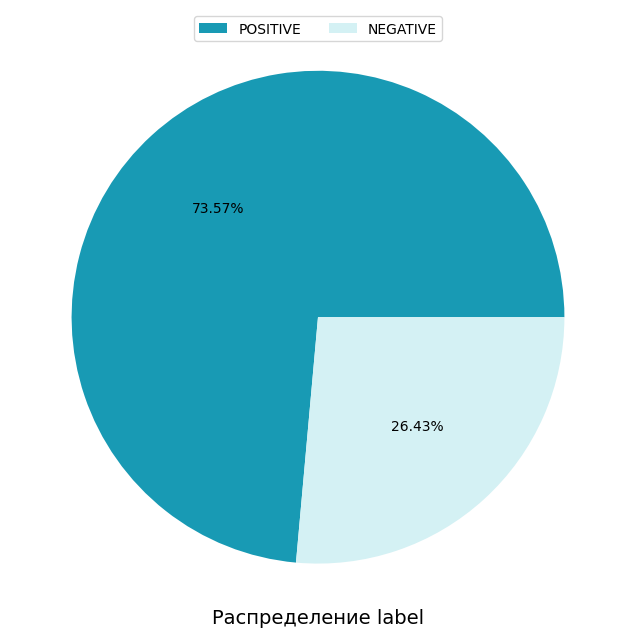

In [65]:

plt.figure(figsize = (8, 8))

labels = ['POSITIVE', 'NEGATIVE']
colors = ['#189AB4', '#D4F1F4']
plt.pie(df['label'].value_counts(), autopct='%0.2f%%',colors=colors)

plt.title('Распределение label', size=14, y=-0.01)
plt.legend(labels, ncol=2, loc=9)
plt.show()

<Axes: >

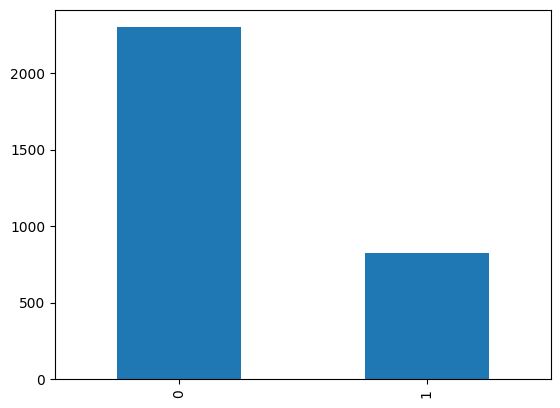

In [66]:
df['label'].value_counts().plot.bar()

*Комментарий:* Из графика видно, что присутствует сильный дисбаланс классов 

In [67]:

user_target =df.groupby('id3')['label'].mean()

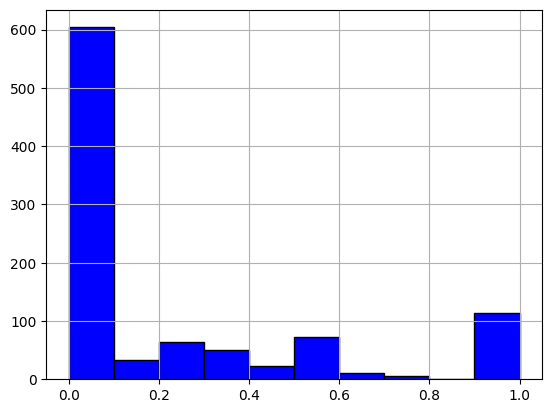

In [68]:
plt.hist(user_target, color = 'blue', edgecolor = 'black',
         bins = 10);
plt.grid(True)

*Комментарий:* Из графика видно, что окола 158 пользователей пишут фейковые отзывы 

In [69]:
fake_users = user_target.loc[user_target==1].index.to_list()

In [70]:
df.loc[df['id3'].isin(fake_users)]

,id3,text,f1,f2,f3,f4,f5,f6,f7,f8,label
1,2324030737335224220,Запах по сравнению с обычным DOVE никакой. Оно...,10,6,2.700000,46,4,4.434783,90,109,1
13,5470748928248412803,"Доставка-скорость света! Отличная ёмкость, каж...",35,34,4.571429,18,1,4.833333,44,50,1
23,5576082564072164535,︎ ︎ ︎ ︎ ︎ ︎,8,7,5.000000,96,27,4.520833,12,13,1
60,7610598891996405620,К камню претензий нет. Неограненный берилл. Вс...,59,44,4.576271,2,2,3.500000,82,120,1
63,3167186606958567184,Классная вещь.,5,2,5.000000,100,18,5.000000,4,4,1
...,...,...,...,...,...,...,...,...,...,...,...
2916,7825013314613369623,Спасибо большое.,1,1,5.000000,23,2,4.260870,2,3,1
2924,10161588360784006515,"качество пленки классное, пользоваться удобно",3,3,5.000000,1312,242,4.911585,15,20,1
2933,11181794830612897654,Товар пришел разбитым. Возврат не приняли. По ...,8,8,4.000000,74,23,3.972973,55,62,1
2948,7022523323558376342,"Бомбическая штука,аромат супер не стягивает кожу",31,30,4.516129,482,45,4.533195,46,57,1


*Комментарий:* 

In [71]:
feats_corr = df[['f1','f2','f3','f4','f5','f6','f7','f8']].corr()

<Axes: >

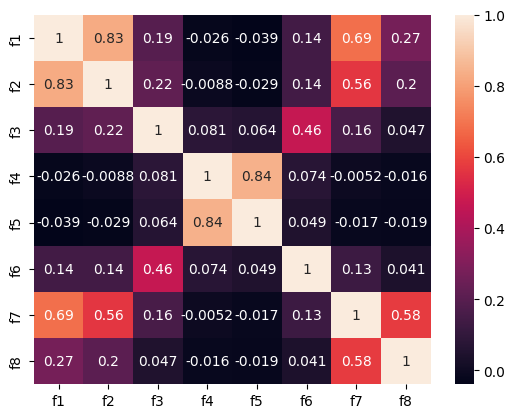

In [72]:
sns.heatmap(feats_corr, annot = True,fmt='.2g')

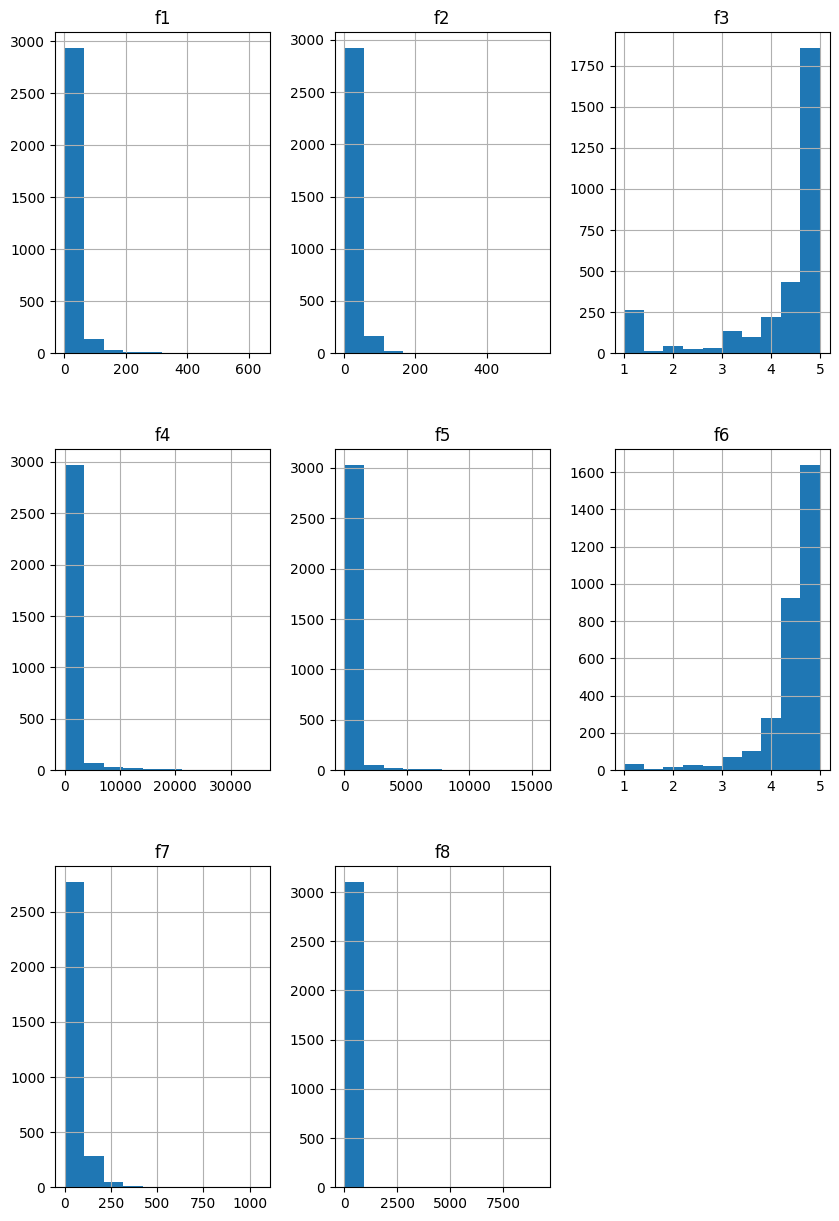

In [73]:
df[['f1','f2','f3','f4','f5','f6','f7','f8']].hist(figsize=(10,15));

*Комментарий:* На основе EDA нельзя сделать вывод о том какие f-лучше всего оставить. Но на первый взгляд, кажется, что f6,f3 - является оценкой в чистом виде.  

<Axes: >

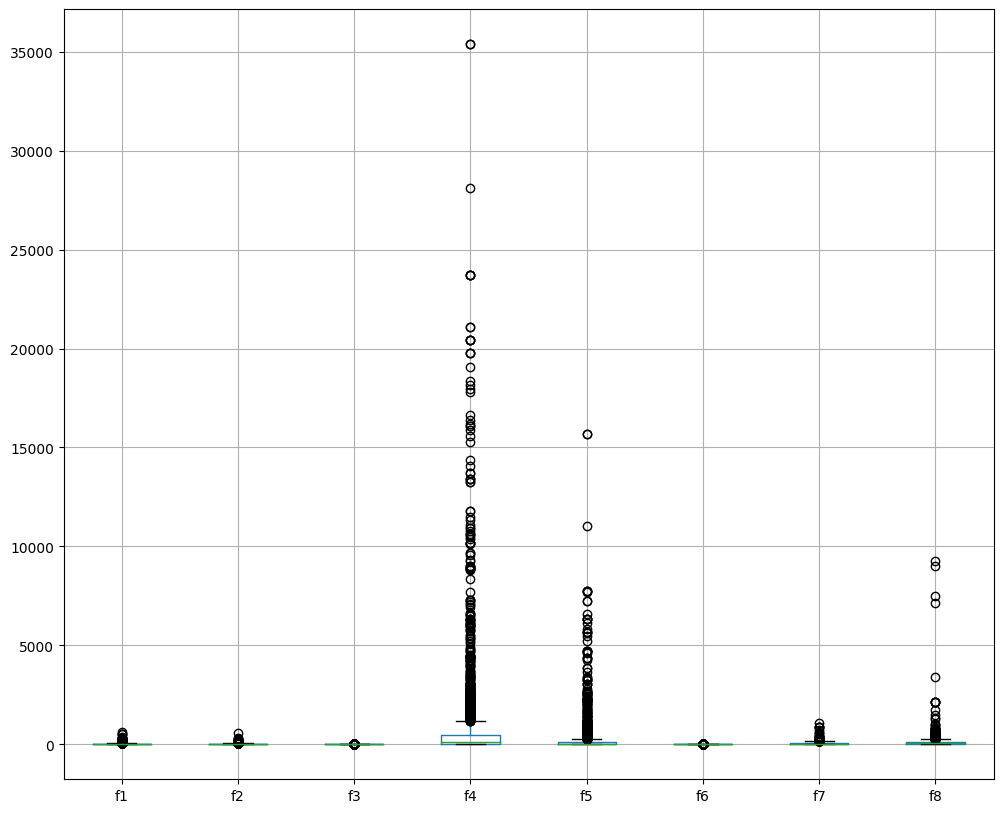

In [74]:
df[['f1','f2','f3','f4','f5','f6','f7','f8']].boxplot(figsize=(12,10))

*Комментарий:* Очистим от лишних символов текст

In [75]:
def cleaning(text):
    text = re.sub(r"(?:\n|\r)", " ", text)
    text = re.sub(r"[^a-zA-Z+а-яА-ЯёЁ ]+", "", text).strip()
    
    text = text.lower()
    return text



df['text'] = df['text'].apply(cleaning)

In [76]:
df

,id3,text,f1,f2,f3,f4,f5,f6,f7,f8,label
0,18254136755182295358,хотела купить на замену старыхпо итогу эти уж...,1,1,1.000000,11,13,4.272727,18,36,0
1,2324030737335224220,запах по сравнению с обычным dove никакой оно ...,10,6,2.700000,46,4,4.434783,90,109,1
2,4904562693381133981,кабель подошёл хорошо работает,4,4,4.000000,14,0,4.500000,4,6,0
3,13541353053200353836,восторг очень приятный аромат держится долго о...,6,6,5.000000,374,30,4.772727,14,15,1
4,9121890650636487522,визуально все хорошо не пробовали купили в под...,19,18,5.000000,6,4,5.000000,26,33,0
...,...,...,...,...,...,...,...,...,...,...,...
3118,6836784353719029392,стекло не плохоено есть один минус на техно сп...,2,2,3.000000,19,1,4.263158,9,9,0
3119,12090430373311552618,всё пришло запаковано ничего не сломано лучше ...,8,8,4.375000,131,83,4.183206,18,18,0
3120,18003133089489520237,мне нравятся я очень аллергичная посоветовал ...,13,12,5.000000,145,2,4.944828,12,14,0
3121,12214993272083833542,спасибо целая пришла хорошо упаковано,3,3,5.000000,205,19,4.648780,103,155,0


In [77]:
from pymystem3 import Mystem

In [78]:
corpus = df['text']

In [79]:
corpus 


0       хотела купить на замену старыхпо итогу эти  уж...
1       запах по сравнению с обычным dove никакой оно ...
2                          кабель подошёл хорошо работает
3       восторг очень приятный аромат держится долго о...
4       визуально все хорошо не пробовали купили в под...
                              ...                        
3118    стекло не плохоено есть один минус на техно сп...
3119    всё пришло запаковано ничего не сломано лучше ...
3120    мне нравятся  я очень аллергичная посоветовал ...
3121               спасибо  целая пришла хорошо упаковано
3122               бур нормальный но выбрал другую модель
Name: text, Length: 3122, dtype: object

In [88]:
def lemmatize(text):
    m = Mystem()
    lemm_list = m.lemmatize(text)
    lemm_text = "".join(lemm_list)
        
    return lemm_text
corpus[0] = lemmatize((corpus[0]))
corpus

0       хотеть купить на замена старыхпо итог этот  уж...
1       запах по сравнению с обычным dove никакой оно ...
2                          кабель подошёл хорошо работает
3       восторг очень приятный аромат держится долго о...
4       визуально все хорошо не пробовали купили в под...
                              ...                        
3118    стекло не плохоено есть один минус на техно сп...
3119    всё пришло запаковано ничего не сломано лучше ...
3120    мне нравятся  я очень аллергичная посоветовал ...
3121               спасибо  целая пришла хорошо упаковано
3122               бур нормальный но выбрал другую модель
Name: text, Length: 3122, dtype: object

In [81]:
#  мешок слов с учёта стоп-слов
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english','russian'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


*Комментарий:* Разделю выборки целевой показатель label

In [93]:
features = df.drop('label', axis=1)
target = df['label']

In [92]:
print(features.shape[0])
print(target.shape[0])

3122
3122
